In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime
from netCDF4 import Dataset


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy


In [25]:
HOME = "/global/homes/q/qnicolas/"
control_sfcvars = xr.open_dataset(HOME+"WRF/processed/wrf.mountain.100km.sfc.nc",use_cftime=True)
control_sfcvars['time'] = (control_sfcvars.indexes['time'].shift(2+(datetime.datetime(1970,1,1)-datetime.datetime(1,1,1)).days,'D')
                  ).to_datetimeindex()
control_plvars = xr.open_dataset(HOME+"WRF/processed/wrf.mountain.100km.pl.nc",use_cftime=True) #Took 25min to produce with wrfoutocf
control_plvars['time'] = (control_plvars.indexes['time'].shift(2+(datetime.datetime(1970,1,1)-datetime.datetime(1,1,1)).days,'D')
                  ).to_datetimeindex()
control_plvars=control_plvars.rename({'pressure':'level'})

norad_allvars = xr.open_dataset(HOME+"WRF/processed/wrf.mountain.100km.norad.nc",use_cftime=True)
norad_allvars['time'] = (norad_allvars.indexes['time'].shift(2+(datetime.datetime(1970,1,1)-datetime.datetime(1,1,1)).days,'D')
                       ).to_datetimeindex()
norad_allvars=norad_allvars.rename({'pressure':'level'})


# Precip maps

In [7]:
control_precip_g = 4*control_sfcvars.precip_g.isel(time=range(100,401)).diff('time').assign_coords(time = control_sfcvars.precip_g.time.isel(time=range(100,400)))
control_precip_c = 4*control_sfcvars.precip_c.isel(time=range(100,401)).diff('time').assign_coords(time = control_sfcvars.precip_g.time.isel(time=range(100,400)))
control_meanprecip = (control_precip_g+control_precip_c).mean("time")


norad_precip_g = 4*norad_allvars.precip_g.isel(time=range(100,401)).diff('time').assign_coords(time = control_sfcvars.precip_g.time.isel(time=range(100,400)))
norad_precip_c = 4*norad_allvars.precip_c.isel(time=range(100,401)).diff('time').assign_coords(time = control_sfcvars.precip_g.time.isel(time=range(100,400)))
norad_meanprecip = (norad_precip_g+norad_precip_c).mean("time")



Text(0.5, 1.0, 'Mean precip, no radiation')

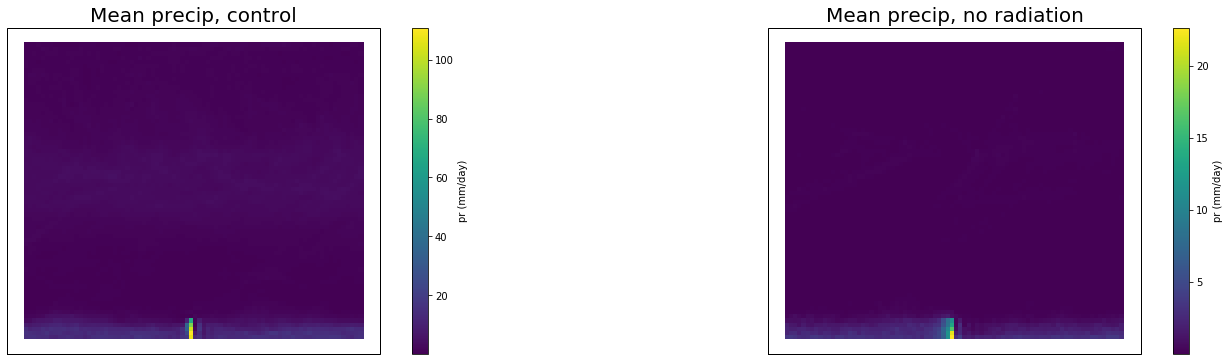

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,6),subplot_kw={'projection': ccrs.PlateCarree()})

control_meanprecip.plot(ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)"})#,"ticks":np.arange(-0.02,0.021,0.004)},levels=np.linspace(0,40.,100))
norad_meanprecip.plot(ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)"})#,"ticks":np.arange(0.,41.,10.)},levels=np.linspace(0,40.,100))
ax1.set_title("Mean precip, control",fontsize=20)
ax2.set_title("Mean precip, no radiation" ,fontsize=20)

# Zonal-mean comparison

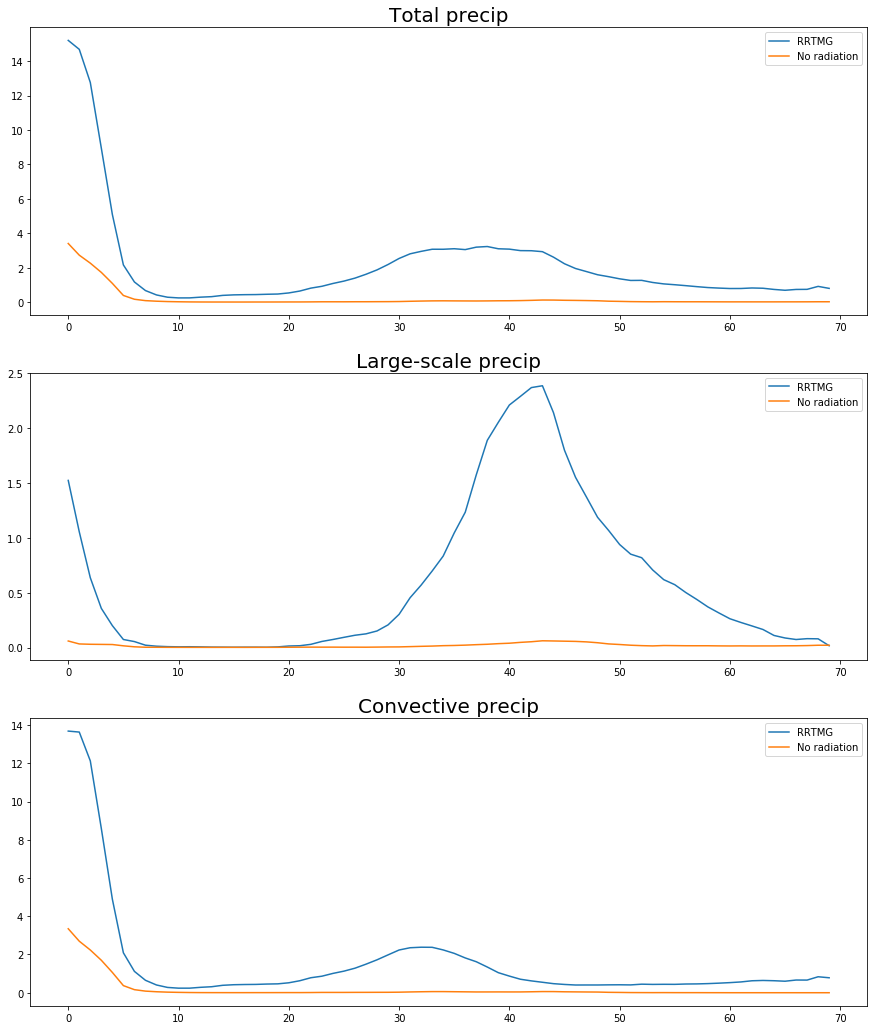

In [9]:
fig, ax = plt.subplots(3,1,figsize=(15,18))

ax[0].plot(control_meanprecip.south_north,control_meanprecip.mean("west_east"),         label="RRTMG")
ax[1].plot(control_meanprecip.south_north,(control_precip_g).mean(["time","west_east"]),label="RRTMG")
ax[2].plot(control_meanprecip.south_north,(control_precip_c).mean(["time","west_east"]),label="RRTMG")


ax[0].plot(control_meanprecip.south_north,norad_meanprecip.mean("west_east")         , label="No radiation")
ax[1].plot(control_meanprecip.south_north,(norad_precip_g).mean(["time","west_east"]), label="No radiation")
ax[2].plot(control_meanprecip.south_north,(norad_precip_c).mean(["time","west_east"]), label="No radiation")


ax[0].set_title("Total precip",fontsize=20)
ax[1].set_title("Large-scale precip",fontsize=20)
ax[2].set_title("Convective precip",fontsize=20)
ax[0].legend()
ax[1].legend()
ax[2].legend()

# Temperature

In [16]:
control_t = control_plvars.T_p.isel(time=range(100,401))
control_meants = control_t.sel(level=800).mean("time")

norad_t = norad_allvars.T_p.isel(time=range(100,401))
norad_meants = norad_t.sel(level=800).mean("time")


Text(0.5, 1.0, 'Mean 800mb temperature, no radiation')

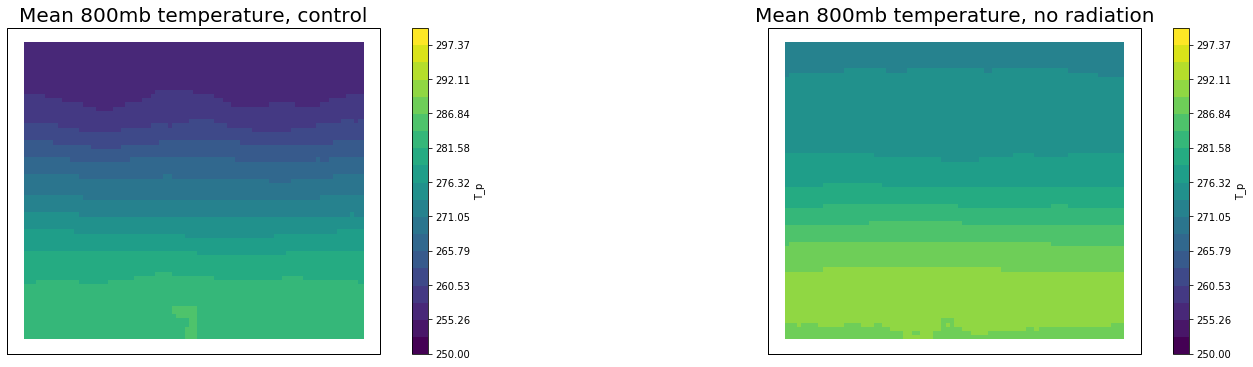

In [20]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,6),subplot_kw={'projection': ccrs.PlateCarree()})

control_meants.plot(ax=ax1,transform=ccrs.PlateCarree(),levels=np.linspace(250,300,20))
norad_meants.plot(ax=ax2,transform=ccrs.PlateCarree(),levels=np.linspace(250,300,20))
ax1.set_title("Mean 800mb temperature, control",fontsize=20)
ax2.set_title("Mean 800mb temperature, no radiation" ,fontsize=20)

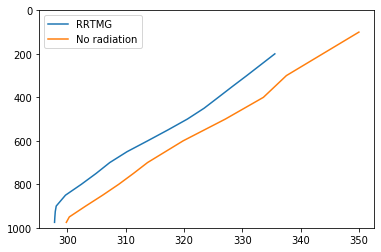

In [31]:
control_theta = (control_t.level/1000)**(-0.286)*control_t.isel(south_north=range(10)).mean(["time","west_east","south_north"])
norad_theta = (norad_t.level/1000)**(-0.286)*norad_t.isel(south_north=range(10)).mean(["time","west_east","south_north"])

plt.plot(control_theta,control_t.level,label="RRTMG")
plt.plot(norad_theta,norad_t.level,label="No radiation")
plt.ylim(1000,0)
plt.legend()